# 0. My notes

Demontis, Ambra, et al. "Why do adversarial attacks transfer? Explaining transferability of evasion and poisoning attacks." 28th USENIX security symposium (USENIX security 19). 2019.

To reproduce the results, use this code from SecML library. Instead of the toy example with CDLRandomBlobs, you can load MNIST dataset from MNIST data loader and you can get DREBIN dataset here. 


Paper:https://www.usenix.org/system/files/sec19-demontis.pdf


Useful links from the projectfile:

https://secml.readthedocs.io/en/v0.15/tutorials/13-Android-Malware-Detection.html

https://secml.readthedocs.io/en/v0.15/secml.data.loader.html#module-secml.data.loader.c_dataloader_mnist

https://figshare.com/articles/dataset/Android_malware_dataset_for_machine_learning_2/5854653

20-25 min for the presentation + 5-10 for questions

Don't show code on the slides

Present content of the paper + show what we have done with some graphs or tables

Be curious - look for why results are different or play with some variables

**Remember to run it in the conda - I have python 3.10 and I need 3.8 for secml**

https://secml.readthedocs.io/en/v0.15/tutorials/04-Transferability.html

This link seems more useful than the one with malware detection.

**********************************************

# Part A - evasion

# 1. Loading the dataset

By deafult there were blobs, I replaced them with MNIST digits

In [2]:
#Load the dataset
random_state = 999

from secml.data.loader import CDataLoaderMNIST
mnist_loader = CDataLoaderMNIST()
tr = mnist_loader.load(ds='training', digits=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))
ts = mnist_loader.load(ds='testing', digits=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

#This dataset is not normalized, so it has to be normalized similarly to blobs

# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

# Get the size of the training dataset
num_samples, num_features = tr.X.shape
tr1 = tr[:int(num_samples/2), :]  # Source classifier training set
tr2 = tr[int(num_samples/2):, :]  # Target classifier training set

# 2. Training surrogate classifier

I added a possibility to train multiple surrogate models at once (default code supprted only 1 surrogate model at a time)

In [4]:
from collections import namedtuple
CLF = namedtuple('CLF', 'clf_name clf xval_parameters')

from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
# Binary classifiers
from secml.ml.classifiers import CClassifierSVM, CClassifierSGD
# Natively-multiclass classifiers
from secml.ml.classifiers import CClassifierKNN, CClassifierDecisionTree, CClassifierRandomForest

# Let's create a 3-Fold data splitter
from secml.data.splitter import CDataSplitterKFold
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

surr_clf_list = [
    CLF(clf_name='SVM Linear H',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [100]}),
    CLF(clf_name='SVM Linear L',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [0.1]})
]

In [ ]:
for i, test_case in enumerate(surr_clf_list):
    clf = test_case.clf
    xval_params = test_case.xval_parameters

    print("Training of {:} ...".format(test_case.clf_name))
    clf.fit(tr1.X, tr1.Y)

    # Predictions on test set and performance evaluation
    y_pred = clf.predict(ts.X)
    acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

    print("Classifier: {:}\tAccuracy: {:.2%}".format(test_case.clf_name, acc))


print("\nTraining the target classifiers...")

# 3. Prepare a function to visualize the attack on digits

In [37]:
#Visualise the attack function

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline
digits=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
# Let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, digs, n_display=6):
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display*2, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()



# 4. Run an evasion attack on surrogate model 

Here I played with numbers. 

And reduced complexity by slicing the dataset. I know it is not good, but my computer didn't like big dataset.

Attack started...
Attack complete!
Dataset before the attack


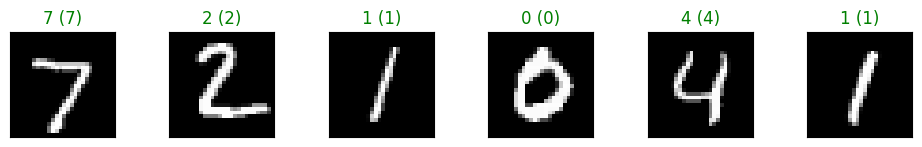

Dataset after the attack


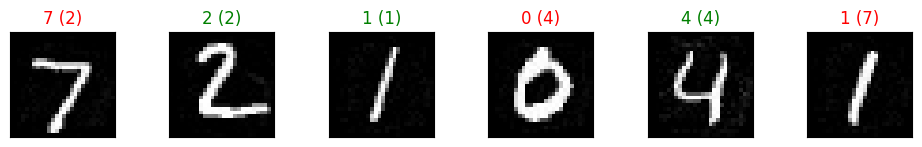

Attack started...
Attack complete!
Dataset before the attack


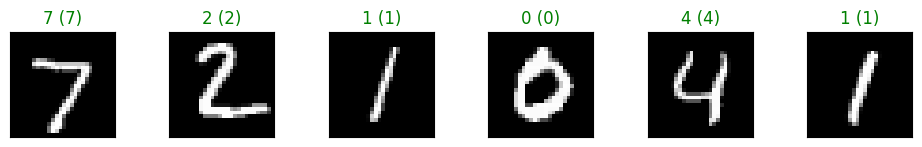

Dataset after the attack


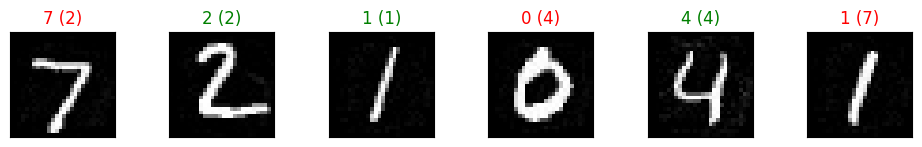

In [25]:
#It would take me around 170 hours to run evasion attack on the default configuration. So, I simplified it.
from secml.adv.attacks.evasion import CAttackEvasionPGDLS

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 5           # Maximum perturbation
lb, ub = 0, 1      # Bounds of the attack space. Can be set to `None` for unbounded
y_target = 2       # `error-specific` attack. None for `error-generic`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 5e-1,
    'eta_min': 0.1,
    'eta_max': None,
    'max_iter': 25,
    'eps': 5
}

#Again it is very computationally intensive, run a test on a small subset (5%) and check time
smallerts = ts[:500, :]
Adv_ds = []

for i, test_case in enumerate(surr_clf_list):
    
    pgd_ls_attack = CAttackEvasionPGDLS(
        classifier=test_case.clf,
        double_init_ds=tr1,
        double_init=False,
        distance=noise_type,
        dmax=dmax,
        lb=lb, ub=ub,
        solver_params=solver_params,
        y_target=y_target)

    # Run the evasion attack on x0
    print("Attack started...")
    y_pred, scores, adv_ds, f_obj = pgd_ls_attack.run(smallerts.X, smallerts.Y)
    print("Attack complete!")

    Adv_ds.append(adv_ds)
    
    print("Dataset before the attack")
    show_digits(smallerts.X, surr_clf.clf.predict(smallerts.X), smallerts.Y, digits)
    print("Dataset after the attack")
    show_digits(adv_ds.X, surr_clf.clf.predict(adv_ds.X), adv_ds.Y, digits)
    


# 5. Train other models

There is sth wrong with Logistic SGD

Change "loss = log" to "loss = log_loss" in the:

 CLF(clf_name='Logistic (SGD)',
        clf=CClassifierMulticlassOVA(
            CClassifierSGD, regularizer='l2', loss='log_loss',
            random_state=random_state),
        xval_parameters={'alpha': [1e-6, 1e-5, 1e-4]}),
        
This change causes:  no class of type `log_loss` is a subclass of 'CLoss' from module 'secml.ml.classifiers.loss.c_loss'

In [88]:
target_clf_list = [
    CLF(clf_name='SVM Linear H',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [100]}),
     CLF(clf_name='Decision Tree H',
        clf=CClassifierDecisionTree(random_state=random_state),
        xval_parameters={'max_depth': [16]}),
    CLF(clf_name='Random Forest H',
        clf=CClassifierRandomForest(random_state=random_state),
        xval_parameters={'n_estimators': [30], 'max_depth': [16]}),
    CLF(clf_name='kNN',
        clf=CClassifierKNN(),
        xval_parameters={'n_neighbors': [30]}),
]

'''Run one by one (or in smaller batches) or my computer will die 
    CLF(clf_name='Decision Tree L',
        clf=CClassifierDecisionTree(random_state=random_state),
        xval_parameters={'max_depth': [8]}),
    CLF(clf_name='SVM RBF H',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='rbf'),
        xval_parameters={'C': [100],  'kernel.gamma': [0.01]}),
    CLF(clf_name='SVM RBF L',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='rbf'),
        xval_parameters={'C': [1],  'kernel.gamma': [0.01]}),
    CLF(clf_name='SVM Linear L',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [0.1]}),
    CLF(clf_name='Random Forest H',
        clf=CClassifierRandomForest(random_state=random_state),
        xval_parameters={'n_estimators': [30], 'max_depth': [16]}),
    CLF(clf_name='Random Forest L',
        clf=CClassifierRandomForest(random_state=random_state),
        xval_parameters={'n_estimators': [30], 'max_depth': [8]}),
    CLF(clf_name='kNN',
        clf=CClassifierKNN(),
        xval_parameters={'n_neighbors': [30]}),
'''

print("\nClassifiers selected...")


Classifiers selected...


SVM Linear is fine

SVM RBF (both H and L) makes my computer freeze, I have 16GB of RAM and it is still not enough, I cannot run it

Decision tree is fast

kNN is not used in the paper

In [89]:
for i, test_case in enumerate(target_clf_list):
    clf = test_case.clf
    xval_params = test_case.xval_parameters

    print("Training of {:} ...".format(test_case.clf_name))
    clf.fit(tr2.X, tr2.Y)

    # Predictions on test set and performance evaluation
    y_pred = clf.predict(ts.X)
    acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

    print("Classifier: {:}\tAccuracy: {:.2%}".format(test_case.clf_name, acc))

Training of SVM Linear H ...
Classifier: SVM Linear H	Accuracy: 8.30%
Training of Decision Tree H ...
Classifier: Decision Tree H	Accuracy: 14.82%
Training of Random Forest H ...
Classifier: Random Forest H	Accuracy: 6.45%
Training of kNN ...
Classifier: kNN	Accuracy: 3.77%


# 6. Measure transferability

Here I changed hardcoded 6 elements into len(target_clf_list), to test at lower number of classifiers at the time (or otherwise my computer would not handle it). Moreover, if we were sticking strictly to the paper it would be 12 classifiers in total (H and L version for each).

I added an option to visualize error rate prior to the attack.

I also added possibility to check multiple surrogate models at once (default code supprted only 1 surrogate model at a time)

Test error (no attack): 8.40% for SVM Linear H

Testing transferability of SVM Linear H using SVM Linear H (surrogate) 

Testing transferability of SVM Linear H using SVM Linear L (surrogate) 
Test error (no attack): 16.00% for Decision Tree H

Testing transferability of Decision Tree H using SVM Linear H (surrogate) 

Testing transferability of Decision Tree H using SVM Linear L (surrogate) 
Test error (no attack): 6.60% for Random Forest H

Testing transferability of Random Forest H using SVM Linear H (surrogate) 

Testing transferability of Random Forest H using SVM Linear L (surrogate) 
Test error (no attack): 4.60% for kNN

Testing transferability of kNN using SVM Linear H (surrogate) 

Testing transferability of kNN using SVM Linear L (surrogate) 


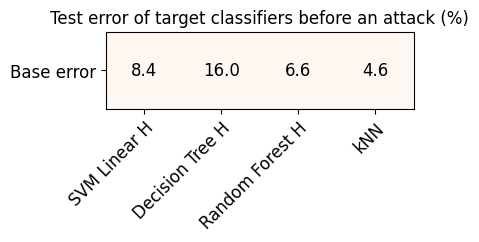

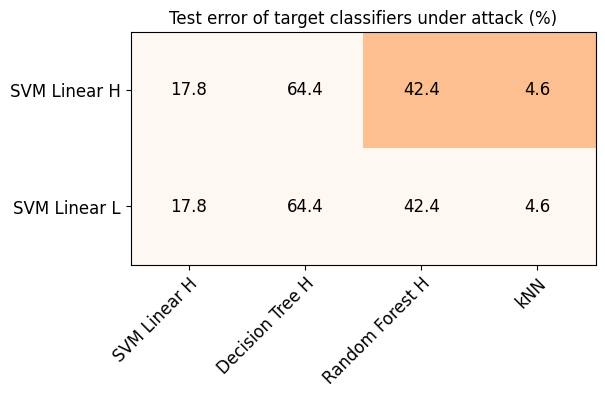


Average transfer rate: 32.30%


In [90]:
# Metric to use for testing transferability
from secml.ml.peval.metrics import CMetricTestError
metric = CMetricTestError()

error = []
trans_error = []
transfer_rate = 0.0
for target_clf in target_clf_list:
    origin_error = metric.performance_score(
                y_true=smallerts.Y, y_pred=target_clf.clf.predict(smallerts.X))

    print("Test error (no attack): {:.2%} for {}".format(origin_error, target_clf.clf_name))
    error.append(origin_error)   
    for i in range(len(surr_clf_list)):

        print("\nTesting transferability of {} using {} (surrogate) ".format(target_clf.clf_name, surr_clf_list[i].clf_name))
        trans_error_clf = metric.performance_score(
            y_true=smallerts.Y, y_pred=target_clf.clf.predict(Adv_ds[i].X))

        trans_error.append(trans_error_clf)
        transfer_rate += trans_error_clf

        ''' Just to see how the classification worked
        print("Dataset before the attack")
        show_digits(smallerts.X, target_clf.clf.predict(smallerts.X), smallerts.Y, digits)
        print("Dataset after the attack")
        show_digits(Adv_ds[i].X, target_clf.clf.predict(Adv_ds[i].X), Adv_ds[i].Y, digits)
        '''
        
# Computing the transfer rate
transfer_rate /= len(target_clf_list)
transfer_rate /= len(surr_clf_list)

from secml.array import CArray
trans_acc = CArray(trans_error) * 100  # Show results in percentage
err = CArray(error) * 100

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline


#Error before an attack
fig2 = CFigure(height=1)
b = fig2.sp.imshow(err.reshape((1, len(target_clf_list))),
                  cmap='Oranges', interpolation='nearest',
                  alpha=.65, vmin=60, vmax=70)

fig2.sp.xticks(CArray.arange((len(target_clf_list))))
fig2.sp.xticklabels([c.clf_name for c in target_clf_list],
                   rotation=45, ha="right", rotation_mode="anchor")
fig2.sp.yticks([0])
fig2.sp.yticklabels(["Base error"])

for i in range(len(target_clf_list)):
        fig2.sp.text(i, 0, err[i].round(2).item(), va='center', ha='center')
        
fig2.sp.title("Test error of target classifiers before an attack (%)")

fig2.show()

#Attack-induced errors
fig = CFigure(height=len(target_clf_list))
a = fig.sp.imshow(trans_acc.reshape((len(surr_clf_list), len(target_clf_list))),
                  cmap='Oranges', interpolation='nearest',
                  alpha=.65, vmin=60, vmax=70)

fig.sp.xticks(CArray.arange((len(target_clf_list))))
fig.sp.xticklabels([c.clf_name for c in target_clf_list],
                   rotation=45, ha="right", rotation_mode="anchor")
fig.sp.yticks(CArray.arange((len(surr_clf_list))))
fig.sp.yticklabels([c.clf_name for c in surr_clf_list])

for i in range(len(target_clf_list)):
    for j in range(len(surr_clf_list)):
        fig.sp.text(i, j, trans_acc[len(surr_clf_list)*i+j].round(2).item(), va='center', ha='center')
        
fig.sp.title("Test error of target classifiers under attack (%)")

fig.show()

print("\nAverage transfer rate: {:.2%}".format(transfer_rate))

**Surogates on the left, test subjects at the bottom**

# Part B - poisoning

There is no code exactly related to the paper that regards poisoning. There is just some basic example of running poisoing attack on SVM.

In [49]:
from secml.adv.attacks import CAttackPoisoningSVM
from secml.ml.classifiers import CClassifierSVM
from secml.ml.peval.metrics import CMetricAccuracy

random_state = 999

#Smaller size or my computer dies
n_tr = 100   # Number of training set samples
n_val = 500  # Number of validation set samples
n_ts = 500   # Number of test set samples
digits = (5, 9)

tr_val = mnist_loader.load('training', digits=digits, num_samples=n_tr + n_val)
ts = mnist_loader.load('testing', digits=digits, num_samples=n_ts)

# Split in training and validation set
tr = tr_val[:n_tr, :]
val = tr_val[n_tr:, :]

# Normalize the features in `[0, 1]`
tr.X /= 255
val.X /= 255
ts.X /= 255

lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
n_poisoning_points = 15  # Number of poisoning points to generate

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.25,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}


# train SVM in the dual space, on a linear kernel, as needed for poisoning
clf = CClassifierSVM(C=1, kernel='linear')

print("Training of classifier...")
clf.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)
metric = CMetricAccuracy()
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
print("Accuracy on test set: {:.2%}".format(acc))


Training of classifier...
Accuracy on test set: 93.60%


There is different way of calling models here for some reason. I need CClassifierSVM rather than CClassifierMulticlassOVA.

It is a little bit problematic, because I cannot use 10 classes, just 2 at a time.

Attack started...
Attack complete!
Original accuracy on test set: 93.60%
Accuracy after attack on test set: 56.20%


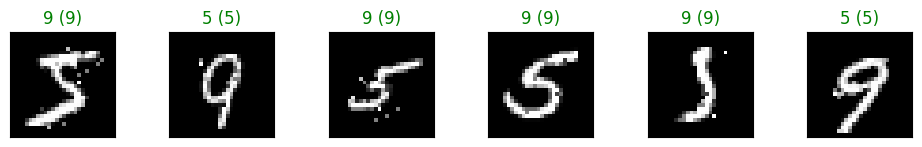

In [50]:
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, _, pois_points_ds, _ = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=clf.predict(ts.X))
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

# Training of the poisoned classifier for visualization purposes
pois_clf = clf.deepcopy()
pois_tr = tr.append(pois_points_ds)  # Join the training set with the poisoning points
pois_clf.fit(pois_tr.X, pois_tr.Y)

#Show results
show_digits(pois_points_ds.X, pois_clf.predict(pois_points_ds.X),
            pois_points_ds.Y, digits)